# STAT 542 / CS 598: Homework 5
Fall 2019, by Edgar Pino

Due: Monday, Oct 28 by 11:59 PM Pacific Time

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import math, random
from functools import partial, reduce
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans as SKMeans
from sklearn.preprocessing import StandardScaler
import time

In [152]:
def get_images_and_labels():
    data = pd.read_csv('zip.train.csv')
    labels = data.V1.to_numpy()
    images = data.drop(columns=['Unnamed: 0', 'V1']).to_numpy()
    return images, labels

In [153]:
images, labels = get_images_and_labels()

# Question 1 [50 Points] K-Means Clustering

In [154]:
def showImage(pixels):
    img_pixels = pixels.reshape((16,16))
    plt.imshow(img_pixels, cmap='gray')
    plt.show()

In [155]:
def euclidean_distance(a, b):
    return np.linalg.norm(a-b)

## [15 Points] Write your own code of k-means that iterates between two steps, and stop when the cluster membership does not change.

In [156]:
class KMeans:
    def __init__(self, k):
        self.k = k          
        self.means = None 
        self.labels = None

    def get_item_label(self, x):
        distances = np.zeros(self.k)

        for i in range(self.k):
            centroid = self.means[i]
            distances[i] = euclidean_distance(centroid, x)

        return np.argmin(distances)
    
    
    def get_cluster_labels(self, data):
        cluster_labels = [None] * data.shape[0]

        for index in range(len(data)):
            item = data[index]
            label = self.get_item_label(item)
            cluster_labels[index] = label

        return np.array(cluster_labels)
    
    def get_initial_centroids(self, data):
        return data[np.random.choice(data.shape[0], self.k, replace=False)]

    def train(self, data):
        self.means = self.get_initial_centroids(data)
        
        while True:
            new_labels = self.get_cluster_labels(data)

            if np.array_equal(self.labels, new_labels):
                return

            self.labels = new_labels

            for i in range(self.k):
                i_points = [p for p, a in zip(data, self.labels) if a == i]
                if i_points:
                    self.means[i] = np.mean(i_points, axis=0)

## [10 Points] Perform your algorithm with one random initialization with 

In [157]:
np.random.seed(0)

In [158]:
model = KMeans(5)

In [159]:
model.train(images)

### For this question, compare your cluster membership to the true digits

In [160]:
accuracy_score(y_true=labels, y_pred=model.labels)

0.07145796187079961

### What are the most prevalent digits in each of your clusters?

In [161]:
clusters = {}

In [162]:
for i in range(len(model.labels)):
    label = model.labels[i]
    
    if label in clusters:
        clusters[label].append(labels[i])
    else:
        clusters[label] = [labels[i]]

In [163]:
for i in clusters:
    counts = Counter(clusters[i])
    print(f"Cluster {i+1} top 2 most common numbers: {counts.most_common(2)}")

Cluster 2 top 2 most common numbers: [(6, 578), (2, 563)]
Cluster 4 top 2 most common numbers: [(0, 881), (6, 68)]
Cluster 5 top 2 most common numbers: [(7, 629), (9, 609)]
Cluster 1 top 2 most common numbers: [(3, 615), (5, 383)]
Cluster 3 top 2 most common numbers: [(1, 1003), (4, 57)]


## [10 Points] Perform your algorithm with 10 independent initiations with k = 5 and record the best

In [164]:
accuracies = []
pred_labels = []

In [165]:
for i in range(10):
    model = KMeans(5)
    model.train(images)
    pred_labels.append(model.labels)
    accuracies.append(accuracy_score(y_true=labels, y_pred=model.labels))

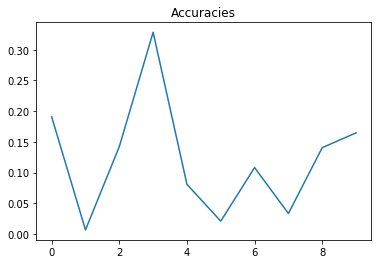

In [166]:
plt.plot(range(10), accuracies)
plt.title('Accuracies')
plt.show()

### For this question, plot your clustering results on a two-dimensional plot, where the two axis are the first two principle components of your data

In [167]:
scaler = StandardScaler()

In [168]:
scaled_images = scaler.fit_transform(images)

In [169]:
pca = PCA(n_components=2)
images_pca = pca.fit_transform(scaled_images)

In [170]:
image_clusters = {}
best_model = pred_labels[3]
for i in range(len(best_model)):
    label = best_model[i]
    
    if label in image_clusters:
        image_clusters[label].append(images_pca[i])
    else:
        image_clusters[label] = [images_pca[i]]

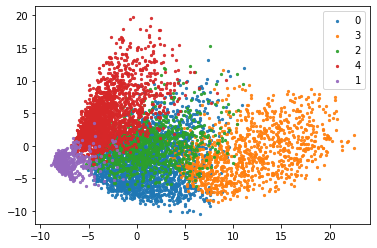

In [171]:
for i in image_clusters:
    cluster = np.array(image_clusters[i])
    plt.scatter(cluster[:, 0], cluster[:, 1], alpha=.9, s=5, label=i)
plt.legend()
plt.show()

## [15 Points] Compare the clustering results from the above two questions with the built-in kmeans() function in R. Use tables/figures to demonstrate your results and comment on your findings.

In [173]:
b_accuracies = []
b_pred_labels = []

In [174]:
for i in range(10):
    kmeans = SKMeans(n_clusters=5).fit(images)
    b_pred_labels.append(kmeans.labels_)
    b_accuracies.append(accuracy_score(y_true=labels, y_pred=kmeans.labels_))

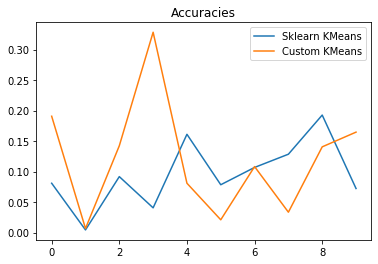

In [175]:
plt.plot(range(10), b_accuracies, label='Sklearn KMeans')
plt.plot(range(10), accuracies, label='Custom KMeans')
plt.title('Accuracies')
plt.legend()
plt.show()

In [176]:
b_image_clusters = {}
best_model = b_pred_labels[7]
for i in range(len(best_model)):
    label = best_model[i]
    
    if label in b_image_clusters:
        b_image_clusters[label].append(images_pca[i])
    else:
        b_image_clusters[label] = [images_pca[i]]

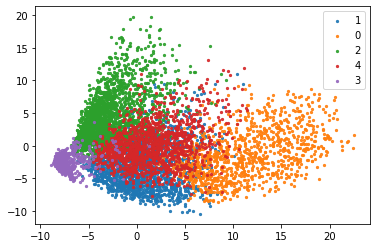

In [177]:
for i in b_image_clusters:
    cluster = np.array(b_image_clusters[i])
    plt.scatter(cluster[:, 0], cluster[:, 1], alpha=.9, s=5, label=i)
plt.legend()
plt.show()

It appears that my custom KMeans algorithm performs about the same as the one from Sklearn. It starts about the same, my kmeans performs better at the 3rd iteration and then the Sklearn model peforms better. This is most likely do to the random centroids being selected every time. There can also be a problem of high dimensions but that's not very likely. 

# Question 2 [50 Points] Two-dimensional Gaussian Mixture Model

In [178]:
import numpy as np
import random
import math

In [179]:
faithful = pd.read_csv('./faithful.csv').drop(columns=['row']).to_numpy()

In [180]:
class MyGMM:
    def __init__(self, K, data, mu, sigma, likelihood_threshold=1e-3):
        self.K = K
        self.data = np.array(data)
        self.N = len(data)
        self.mu = np.array(mu)
        self.sigma = np.array(sigma)
        self.likelihood_threshold = likelihood_threshold
        self.p = np.array([0.5, 0.5])
        self.gammas = np.zeros([K, len(data)])
        self.likelihood = None

    def get_normal_prob_distribution(self, Xi, Uk, Sk, d):
        first = 1 / pow((2 * math.pi), -d / 2)

        exp = pow(abs(np.linalg.det(Sk)), -1 / 2) * np.exp(
            -1 / 2 * np.dot(np.dot((Xi - Uk).T, np.linalg.inv(Sk)), (Xi - Uk))
        )

        return first * exp

    def calculate_m_likelihood(self):
        new_likelihood = 0
        for i in range(self.N):
            temp = 0
            for k in range(self.K):
                temp += self.p[k] * self.get_normal_prob_distribution(
                    self.data[i].T, self.mu[k].T, self.sigma[k], self.data.shape[1]
                )
            new_likelihood += np.log(temp)

        return new_likelihood

    def e_step(self):
        s = np.zeros(self.N)
        for i in range(self.N):
            temp_array = np.zeros(self.K)
            for c_k in range(self.K):
                temp_array[c_k] = float(
                    self.p[c_k]
                ) * self.get_normal_prob_distribution(
                    self.data[i].T, self.mu[c_k].T, self.sigma[c_k], self.data.shape[1]
                )
                s[i] += temp_array[c_k]
            for c_k in range(self.K):
                self.gammas[c_k][i] = temp_array[c_k] / s[i]

    def m_step(self):
        for c_k in range(self.K):
            self.p[c_k] = np.sum(self.gammas[c_k]) / self.N
            total = np.zeros(self.mu.shape[1])

            for i in range(self.N):
                total += self.gammas[c_k][i] * self.data[i]
            self.mu[c_k] = total / np.sum(self.gammas[c_k])

            summ = np.zeros([self.data.shape[1], self.data.shape[1]])
            for i in range(self.N):
                if self.data[i].ndim == 1:
                    data_temp = self.data[i].reshape(self.data.shape[1], 1)
                    mu_temp = self.mu[c_k].reshape(self.mu.shape[1], 1)
                    diff_temp = data_temp - mu_temp
                    summ += self.gammas[c_k][i] * np.dot(diff_temp, diff_temp.T)
                else:
                    summ += self.gammas[c_k][i] * np.dot(
                        self.data[i] - self.mu[i], (self.data[i] - self.mu[i]).T
                    )

            self.sigma[c_k] = summ / np.sum(self.gammas[c_k])

    def fit(self):
        start = time.time()
        new_likelihood = self.calculate_m_likelihood()
        recursion = 0
        
        while (recursion == 0) or (new_likelihood - self.likelihood > self.likelihood_threshold):
            self.likelihood = new_likelihood
            self.e_step()
            self.m_step()

            new_likelihood = self.calculate_m_likelihood()
            recursion += 1
            
        end = time.time()
        print("Recursions:", recursion)
        print("Recursions time:", end - start)

In [181]:
Sigma1 = [[0.1, 0], [0, 10]]
Sigma2 = [[0.1, 0], [0, 50]]
Sigmas = np.array([Sigma1, Sigma2])
Mu1 = [3, 80]
Mu2 = [3.5, 60]
Mus = np.array([Mu1, Mu2])

In [182]:
gmm = MyGMM(2, faithful, mu=Mus, sigma=Sigmas)

In [183]:
gmm.fit()

Recursions: 17
Recursions time: 0.6636650562286377


### The distribution parameters p, μ1, Σ1, μ2, and  Σ2 

In [184]:
print('p:', gmm.p)

p: [0.64411726 0.35588274]


In [185]:
print('Mu 1:', gmm.mu[0])

Mu 1: [ 4.28968326 79.96837252]


In [186]:
print('Mu 2:', gmm.mu[1])

Mu 2: [ 2.03641252 54.47875856]


In [187]:
print('Sigma 1:', gmm.sigma[0])

Sigma 1: [[ 0.16994142  0.9402658 ]
 [ 0.9402658  36.04234529]]


In [188]:
print('Sigma 2:', gmm.sigma[1])

Sigma 2: [[ 0.06918678  0.43536718]
 [ 0.43536718 33.69864512]]


### A histogram of the underlying probabilities of the latent variables

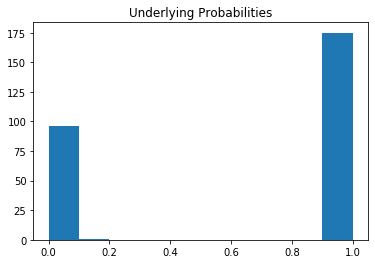

In [192]:
plt.hist(gmm.gammas[0])
plt.title('Underlying Probabilities')
plt.show()

### Plot the normal densities at the 2nd, 3rd, 4th and the final iteration of your algorithm

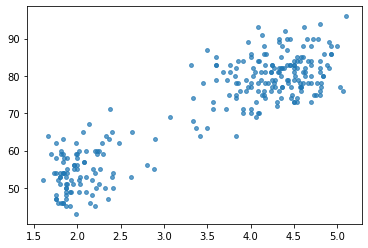

In [190]:
plt.scatter(faithful[:,0], faithful[:,1], alpha=.7, s=15)
plt.show()

## Now, experiment a very different initial value of the parameters and rerun the algorithm. Comment on the efficiency and convergence speed of this algorithm.

In [214]:
Sigma1 = np.array([[5, 0], [5, 20]])
Sigma2 = np.array([[1.9, 0], [4, 15]])
Sigmas = np.array([Sigma1, Sigma2])
Mu1 = np.array([30, 80])
Mu2 = np.array([3.5, 60])
Mus = np.array([Mu1, Mu2])

In [215]:
gmm = MyGMM(2, faithful, mu=Mus, sigma=Sigmas)

In [216]:
gmm.fit()

Recursions: 2
Recursions time: 0.1022791862487793


In [217]:
print('p:', gmm.p)

p: [1.05624275e-19 1.00000000e+00]


In [218]:
print('likelihood:', gmm.likelihood)

likelihood: -289.99162092592945


I changed the sigmas and mus to random number I though of. The recursions went down along with the time but the likelihood is definetly not good. It seems like it jump a little higher and it was the best it could find. 

In [219]:
Sigma1 = [[0.2, 0], [1, 15]]
Sigma2 = [[0.4, 0], [2, 45]]
Sigmas = np.array([Sigma1, Sigma2])
Mu1 = [3, 78]
Mu2 = [2.5, 64]
Mus = np.array([Mu1, Mu2])

In [220]:
gmm = MyGMM(2, faithful, mu=Mus, sigma=Sigmas)

In [221]:
gmm.fit()

Recursions: 11
Recursions time: 0.43671321868896484


In [222]:
print('p:', gmm.p)

p: [0.64408922 0.35591078]


In [223]:
print('likelihood:', gmm.likelihood)

likelihood: -130.45973615430552


This time I changed the sigmas and mus by a little bit only, some went higher and others lower. The recursions are lower compared to the original parameters along with the time. The overall likelihood and p are about the same as the one with the original values.